# 📊 Projet GaïaSense Vision – Modèle Machine Learning (pré-tri)

## 🎯 Objectif du notebook

Ce notebook a pour but de concevoir, entraîner et évaluer un **modèle de Machine Learning supervisé** basé sur l’algorithme **RandomForestClassifier**, chargé de réaliser une **étape de pré-tri logique et contextuelle**, avant toute analyse d’image.

Il s’agit d’un **filtrage intelligent**, fondé uniquement sur des **données tabulaires environnementales**, permettant de :

- Rejeter automatiquement les cas où une analyse visuelle serait inutile (sacs trop jeunes, environnement incohérent…)
- Optimiser les ressources de calcul du modèle CNN en limitant son déclenchement aux cas réellement pertinents
- Intégrer un raisonnement métier directement dans le pipeline IA, via une prédiction binaire sur les conditions de culture

---

## 🧠 Contexte général

Dans le cadre du projet GaïaSense Vision (Certification Alyra – RNCP38616), l’objectif est de développer une **API REST** capable de détecter la contamination de sacs de culture de champignons à partir de photos.  
Cette API s’appuie sur une chaîne d’analyse à deux niveaux :

1. **Un modèle ML classique (Random Forest)**, qui travaille uniquement sur des données tabulaires (capteurs, conditions, type de culture) pour décider si une image doit être transmise ou non au modèle visuel
2. **Un modèle CNN (Deep Learning)**, qui réalise une analyse approfondie de l’image uniquement si le cas est jugé pertinent

---

## 🧬 Données utilisées pour le pré-tri

Le modèle repose uniquement sur des données numériques ou catégorielles liées à l’environnement de culture :

- ✅ **Race du champignon** *(catégorielle)*
- ✅ **Type de substrat** *(catégorielle)*
- ✅ **Temps écoulé depuis inoculation (jours)** *(quantitatif)*
- ⚠️ **Hygrométrie actuelle** *(quantitatif, optionnel)*
- ⚠️ **Taux de CO₂ mesuré** *(quantitatif, optionnel)*

Ces données seront utilisées pour entraîner un modèle capable de prédire un label binaire :  
**“Analyser ou ignorer l’image associée à ce contexte ?”**

---

## 🔧 Outils et bibliothèques utilisés

- `pandas`, `numpy` : manipulation des données
- `scikit-learn` : entraînement du modèle, prétraitement, métriques
- `matplotlib`, `seaborn` : visualisation des performances
- `joblib` : sauvegarde du modèle
- `SimpleImputer`, `LabelEncoder` : gestion des valeurs manquantes et variables catégorielles

---

## ✅ Résultat attendu

À la fin de ce notebook, nous obtiendrons un **modèle Random Forest entraîné, évalué et exporté**, capable de :

- Prédire si une situation de culture justifie l’analyse de l’image par le modèle visuel
- Améliorer les performances globales du système en éliminant les cas hors-contexte
- Être intégré dans une API FastAPI en tant que filtre logique avant traitement image

---

## 👥 Participants au projet GaïaSense Vision

### 🧔 Davy Abderrahman *(Développeur IA – Formation Alyra)*
- **Rôle** : Concepteur principal du projet
- **Responsabilités** :
  - Conception de l’architecture IA (pré-tri logique + Deep Learning visuel)
  - Développement des modèles et de l’API
  - Documentation, tests, déploiement

### 👨 Maxime Cadieux *(Consultant IA – Alyra)*
- **Rôle** : Co-contributeur ML
- **Responsabilités** :
  - Préparation et analyse exploratoire des données
  - Évaluation et suivi des performances du modèle
  - Support technique et structuration métier

### 👩 Naminsita Bakayoko *(Consultante IA – Alyra)*
- **Rôle** : Référente métier
- **Responsabilités** :
  - Définition des règles logiques de déclenchement d’analyse
  - Aide à la création du dataset
  - Validation des résultats selon les logiques agricoles

---

### 🔖 Informations générales

- **Projet** : GaïaSense Vision – Détection de contamination sur sacs de culture de champignons
- **Cadre** : Certification Alyra – RNCP38616
- **Blocs visés** : Bloc 03 (Machine Learning), Bloc 05 (Deep Learning)
- **Date de lancement** : 6 juin 2025
- **Mode** : Collaboration inter-spécialités (Développeur IA + Consultants IA)

---


# Détection GPU + Imports de base


In [161]:
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier, Pool

# (Optionnel) test simple de l'import CatBoost
try:
    model = CatBoostClassifier()
    print("CatBoost est bien installé et prêt à être utilisé.")
except Exception as e:
    print("Problème avec l'installation de CatBoost.")
    print("Erreur :", e)


CatBoost est bien installé et prêt à être utilisé.


# dataset tri et création des données d'entrainement et de test


In [162]:

# Chargement du dataset
input_path = "../data/Dataset_combined_90000_modifie_complexe.csv"
df = pd.read_csv(input_path)

# Vérification rapide
print("Shape initiale :", df.shape)
print(df.head(5))

# Suppression de la colonne id
# df = df.drop(columns=["id"])
# df = df.drop(columns=["co2"])
# df = df.drop(columns=["hygrometrie"])
# Séparation X / y
X = df.drop(columns=["label"])
y = df["label"]

# Découpage train/test stratifié avec 20 % de données prise au hasard pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Reconstruction des DataFrames complets
df_train = X_train.copy()
df_train["label"] = y_train

df_test = X_test.copy()
df_test["label"] = y_test

# Création des dossiers si besoin
os.makedirs("../data/Ml_data/train", exist_ok=True)
os.makedirs("../data/Ml_data/test", exist_ok=True)

# Sauvegarde des fichiers
df_train.to_csv("../data/Ml_data/train/dataset_train.csv", index=False)
df_test.to_csv("../data/Ml_data/test/dataset_test.csv", index=False)

print("Fichiers exportés avec succès.")

Shape initiale : (90000, 7)
    id                  champignon           substrat  Jour_inoculation  \
0  1.0           ganoderma_lucidum             sciure                 0   
1  2.0          hericium_erinaceus        pulpe_cacao                 2   
2  3.0  auricularia_auricula_judae             paille                17   
3  4.0          cyclocybe_aegerita  mix_fumier_paille                 0   
4  5.0   pleurotus_citrinopileatus            maizien                10   

   hygrometrie    co2  label  
0         68.6  392.2      0  
1         61.1  509.4      0  
2         82.7  498.4      0  
3         65.6  550.1      0  
4         73.3  609.6      0  
Fichiers exportés avec succès.


# Verification equilibre des données

In [163]:
df_train = pd.read_csv("../data/Ml_data/train/dataset_train.csv")
print(df_train["label"].value_counts(normalize=True).round(3))

label
0    0.733
1    0.267
Name: proportion, dtype: float64


# 🧠 Modèle de pré-tri tabulaire – RandomForestClassifier

## 🎯 Objectif

L’objectif de ce bloc est de créer, entraîner et évaluer un **modèle de Machine Learning** basé sur un **RandomForestClassifier**, destiné à effectuer une étape de **pré-tri logique** dans le pipeline du projet **GaïaSense Vision**.

Ce modèle ne traite pas d’images, mais uniquement des **données tabulaires environnementales**, afin de prédire si une image future (liée à ces conditions) doit être transmise à l’analyse par Deep Learning.

---

## ⚙️ Structure du pipeline

Ce modèle est encapsulé dans un **pipeline scikit-learn** qui comprend les étapes suivantes :

1. **Chargement des données** (train et test)
2. **Séparation des variables** explicatives (`X`) et de la cible (`y`)
3. **Prétraitement automatique** :
   - **Encodage** des variables catégorielles (`champignon`, `substrat`) via `OneHotEncoder`
   - **Imputation** des valeurs manquantes (`hygrometrie`, `co2`) via `SimpleImputer` (stratégie = moyenne)
4. **Apprentissage du modèle RandomForest**
5. **Évaluation** sur un jeu de test indépendant :
   - `accuracy_score`
   - `classification_report`
   - `confusion_matrix`
6. **Sauvegarde** du modèle pour déploiement futur

---

## 📁 Sources des données

Les données utilisées ici sont issues de la préparation précédente :

- `training/data/Ml_data/train/dataset_train.csv`
- `training/data/Ml_data/test/dataset_test.csv`

Ces fichiers contiennent les colonnes suivantes :
- `champignon` *(catégorielle)*
- `substrat` *(catégorielle)*
- `Jour_inoculation` *(numérique)*
- `hygrometrie` *(numérique, avec valeurs manquantes)*
- `co2` *(numérique, avec valeurs manquantes)*
- `label` *(0 = inutilisable / 1 = à analyser)*

---

## 📌 Objectif final

Ce modèle sera intégré dans l’API GaïaSense Vision comme **filtre rapide**, permettant de :
- Rejeter les cas non pertinents pour l’analyse visuelle
- Optimiser l’usage des ressources IA
- Maintenir une logique métier traçable et interprétable

---


# creation du model et entrainement catboost


In [ ]:
# Entraînement et sauvegarde propre du meilleur modèle CatBoost
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Chargement des données d'entraînement
train_path = "../data/Ml_data/train/dataset_train.csv"
test_path = "../data/Ml_data/test/dataset_test.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


# Séparation X/y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Colonnes catégorielles (inclure la feature combinée)
cat_features = ["champignon", "substrat","Jour_inoculation"]

# Détection GPU et entraînement
try:
    model = CatBoostClassifier(
        iterations=200, # Nombre d'itérations (arbres) pour l'entraînement
        learning_rate=0.1, # Taux d'apprentissage, plus c'est petit, plus l'entraînement est long mais précis
        depth=3, # Profondeur de l'arbre, plus c'est grand, plus le modèle est complexe
        l2_leaf_reg=5, # Régularisation L2 pour éviter l'overfitting 
        task_type="GPU",
        devices='0', 
        verbose=50, # Affichage des logs d'entraînement
        random_state=42,
        
    )
    print("Entraînement CatBoost sur GPU...")
except Exception as e:
    print("GPU non disponible, bascule sur CPU.")
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.01,
        depth=6,
        task_type="CPU",
        verbose=50,
        random_state=42
    )

# Entraînement avec early stopping
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20,
    use_best_model=True
)

# Prédiction et évaluation
preds = model.predict(X_test)
print(f"Accuracy CatBoost : {accuracy_score(y_test, preds):.3f}")
print(classification_report(y_test, preds))

# Sauvegarde du meilleur modèle (formats CatBoost natif et joblib)
model_dir = "../models/Ml_model"
os.makedirs(model_dir, exist_ok=True)
model_path_cbm = os.path.join(model_dir, "model_catboost_best.cbm")
model_path_joblib = os.path.join(model_dir, "model_catboost_best.joblib")
model.save_model(model_path_cbm)
joblib.dump(model, model_path_joblib)
print(f"\nModèle CatBoost sauvegardé :\n- {model_path_cbm}\n- {model_path_joblib}")

Entraînement CatBoost sur GPU...
0:	learn: 0.6709137	test: 0.6709272	best: 0.6709272 (0)	total: 9.44ms	remaining: 1.88s
0:	learn: 0.6709137	test: 0.6709272	best: 0.6709272 (0)	total: 9.44ms	remaining: 1.88s
50:	learn: 0.5524485	test: 0.5515659	best: 0.5515659 (50)	total: 524ms	remaining: 1.53s
50:	learn: 0.5524485	test: 0.5515659	best: 0.5515659 (50)	total: 524ms	remaining: 1.53s
100:	learn: 0.5449820	test: 0.5437974	best: 0.5437974 (100)	total: 959ms	remaining: 940ms
100:	learn: 0.5449820	test: 0.5437974	best: 0.5437974 (100)	total: 959ms	remaining: 940ms
150:	learn: 0.5422056	test: 0.5409185	best: 0.5409185 (150)	total: 1.39s	remaining: 452ms
150:	learn: 0.5422056	test: 0.5409185	best: 0.5409185 (150)	total: 1.39s	remaining: 452ms
199:	learn: 0.5411932	test: 0.5400365	best: 0.5400365 (199)	total: 1.82s	remaining: 0us
bestTest = 0.5400364583
bestIteration = 199
Accuracy CatBoost : 0.741
              precision    recall  f1-score   support

           0       0.74      0.99      0.85 

# test et validation du model


✅ Accuracy CatBoost : 0.900

📊 Rapport de classification :


,precision,recall,f1-score,support
0,0.898893,0.972631,0.934309,13190.000000
1,0.903165,0.700000,0.788709,4810.000000
accuracy,0.899778,0.899778,0.899778,0.899778
macro avg,0.901029,0.836315,0.861509,18000.000000
weighted avg,0.900035,0.899778,0.895402,18000.000000


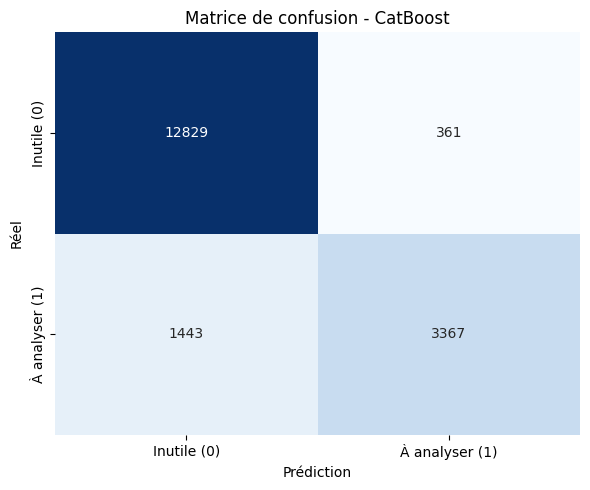

In [165]:
# Imports nécessaires
import joblib
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chemin vers le dossier des modèles
models_dir = "../models/Ml_model"

# Chargement du jeu de test
path_test = "../data/Ml_data/test/dataset_test.csv"
df_test = pd.read_csv(path_test)

# Création des colonnes dérivées nécessaires
def compute_ratio(df):
    return df.apply(
        lambda row: row["co2"] / row["hygrometrie"] if pd.notnull(row["co2"]) and pd.notnull(row["hygrometrie"]) and row["hygrometrie"] != 0 else np.nan,
        axis=1
    )
# df_test["co2_hygro_ratio"] = compute_ratio(df_test)
# df_test["champ_substrat"] = df_test["champignon"] + "_" + df_test["substrat"]

# Séparation X/y
y_test = df_test["label"]
X_test = df_test.drop(columns=["label"])

# Chargement du modèle CatBoost sauvegardé
model = joblib.load("../models/Ml_model/model_catboost_best.joblib")

# Prédiction
preds = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"✅ Accuracy CatBoost : {accuracy:.3f}")

# Rapport de classification
report_dict = classification_report(y_test, preds, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\n📊 Rapport de classification :")
display(report_df)

# Matrice de confusion
cm = confusion_matrix(y_test, preds)
labels = ["Inutile (0)", "À analyser (1)"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title("Matrice de confusion - CatBoost")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()
#%%

# 🔎 Analyse de l'importance des variables (feature importance CatBoost)

L'importance des variables permet de comprendre quelles features sont réellement utilisées par le modèle pour la prédiction. Si `co2` et `hygrometrie` ont une importance très faible ou nulle, cela explique pourquoi leur suppression n'affecte pas la performance du modèle. Ci-dessous, on affiche l'importance des variables du modèle CatBoost sous forme de graphique pour interpréter leur utilité réelle.

/tmp/ipykernel_201790/4108259156.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


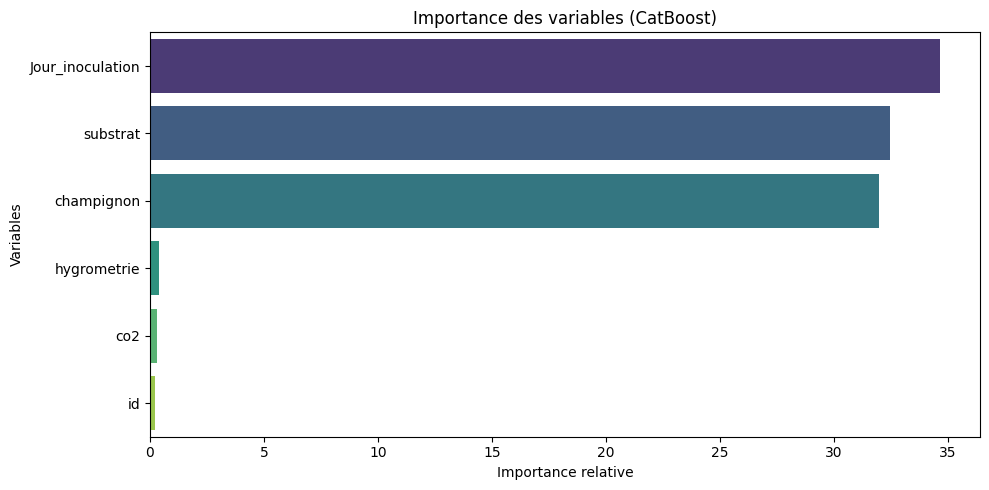

,Variable,Importance
3,Jour_inoculation,34.664488
2,substrat,32.446563
1,champignon,31.971396
4,hygrometrie,0.413307
5,co2,0.300760
0,id,0.203486


In [166]:
# Affichage de l'importance des variables du modèle CatBoost
importances = model.get_feature_importance()
feature_names = X_test.columns

# Tri décroissant pour affichage
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Importance des variables (CatBoost)")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# Affichage tabulaire pour plus de clarté
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
display(feature_importance_df)
